In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as datetime

Plan of attack:
- extract infomation from time:
    - Month
    - Day
    - Coloumn for day or night, or maybe some kind of variable regarding timepoint during daylight hours 
- employ machine learning models
    - I want to particulary focus on hyperparameter tuning and random forests


The dataset includes observations of:

- Solar Irradiance (W/m2)
- Temperature (°F)
- Barometric Pressure (Hg)
- Humidity (%)
- Wind Direction (°)
- Wind Speed (mph)
- Sun Rise/Set Time

Load in the data and investigate the variables

In [2]:
df = pd.read_csv('SolarPrediction.csv')

In [129]:
df.head(5)

,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,date,Month,Day,Year,time_in_secs,TimeSunSet_insec,TimeSunRise_insec,time_to_sunsent,time_to_sunrise,Fraction_during_daylight
0,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00,2016-09-29,9,29,2016,86126,65580,22380,20546,63746,0.0
1,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00,2016-09-29,9,29,2016,85823,65580,22380,20243,63443,0.0
2,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00,2016-09-29,9,29,2016,85526,65580,22380,19946,63146,0.0
3,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00,2016-09-29,9,29,2016,85221,65580,22380,19641,62841,0.0
4,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00,2016-09-29,9,29,2016,84924,65580,22380,19344,62544,0.0


Check for null values and feature type

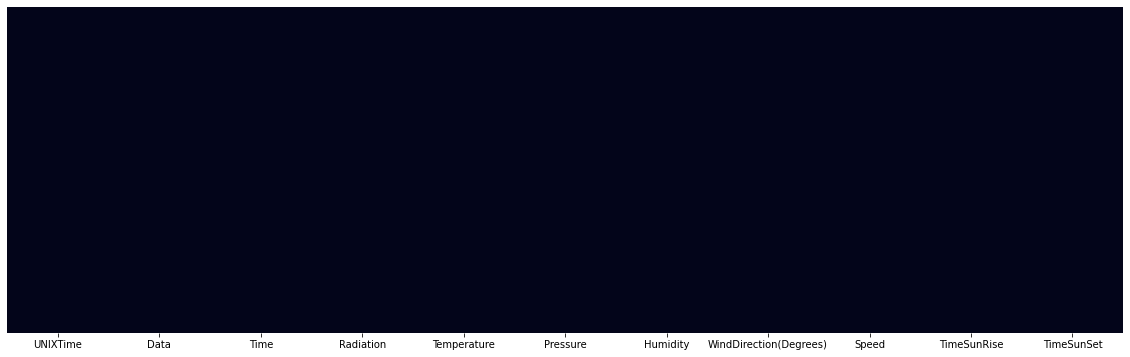

In [4]:
fig, ax = plt.subplots(figsize=(20, 6))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UNIXTime                32686 non-null  int64  
 1   Data                    32686 non-null  object 
 2   Time                    32686 non-null  object 
 3   Radiation               32686 non-null  float64
 4   Temperature             32686 non-null  int64  
 5   Pressure                32686 non-null  float64
 6   Humidity                32686 non-null  int64  
 7   WindDirection(Degrees)  32686 non-null  float64
 8   Speed                   32686 non-null  float64
 9   TimeSunRise             32686 non-null  object 
 10  TimeSunSet              32686 non-null  object 
dtypes: float64(4), int64(3), object(4)
memory usage: 2.7+ MB


Lets begin with some simple intial feature engineering for the time variable

In [6]:
df['date'] = pd.to_datetime(df['Data'],errors='coerce').dt.date
df['Time'] = pd.to_datetime(df['Time'],errors='coerce').dt.time
df['TimeSunSet'] = pd.to_datetime(df['TimeSunSet'],errors='coerce').dt.time
df['TimeSunRise'] = pd.to_datetime(df['TimeSunRise'],errors='coerce').dt.time


In [7]:
df.drop(['UNIXTime','Data'],axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Time                    32686 non-null  object 
 1   Radiation               32686 non-null  float64
 2   Temperature             32686 non-null  int64  
 3   Pressure                32686 non-null  float64
 4   Humidity                32686 non-null  int64  
 5   WindDirection(Degrees)  32686 non-null  float64
 6   Speed                   32686 non-null  float64
 7   TimeSunRise             32686 non-null  object 
 8   TimeSunSet              32686 non-null  object 
 9   date                    32686 non-null  object 
dtypes: float64(4), int64(2), object(4)
memory usage: 2.5+ MB


In [8]:
df['Month'] = df.date.apply(lambda x : x.month)
df['Day'] = df.date.apply(lambda x : x.day)
df['Year'] = df.date.apply(lambda x : x.year)
df['time_in_secs'] = df.Time.apply(lambda x : x.hour*60*60 +x.minute*60 +x.second)
df['TimeSunSet_insec'] = df.TimeSunSet.apply(lambda x : x.hour*60*60 +x.minute*60 +x.second)
df['TimeSunRise_insec'] = df.TimeSunRise.apply(lambda x : x.hour*60*60 +x.minute*60 +x.second)

In [9]:
df.head()

,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,date,Month,Day,Year,time_in_secs,TimeSunSet_insec,TimeSunRise_insec
0,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00,2016-09-29,9,29,2016,86126,65580,22380
1,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00,2016-09-29,9,29,2016,85823,65580,22380
2,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00,2016-09-29,9,29,2016,85526,65580,22380
3,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00,2016-09-29,9,29,2016,85221,65580,22380
4,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00,2016-09-29,9,29,2016,84924,65580,22380


In [10]:
df['time_to_sunsent'] = df['time_in_secs'] - df['TimeSunSet_insec']
df['time_to_sunrise'] = df['time_in_secs'] - df['TimeSunRise_insec'] 

In [12]:
def percent_during_day(df):
    if (df['time_in_secs'] > df['TimeSunRise_insec']) & (df['time_in_secs'] < df['TimeSunSet_insec']):
        return (df['time_in_secs'] - df['TimeSunRise_insec']) / (df['TimeSunSet_insec'] - df['TimeSunRise_insec'])
    else:
        return 0    

In [15]:
df['Fraction_during_daylight'] = df.apply(percent_during_day,axis=1)

In [16]:
df_clean = df.drop(['Time','TimeSunRise', 'TimeSunSet','Year', 'date',],axis = 1)
df_clean.head()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,time_in_secs,TimeSunSet_insec,TimeSunRise_insec,time_to_sunsent,time_to_sunrise,Fraction_during_daylight
0,1.21,48,30.46,59,177.39,5.62,9,29,86126,65580,22380,20546,63746,0.0
1,1.21,48,30.46,58,176.78,3.37,9,29,85823,65580,22380,20243,63443,0.0
2,1.23,48,30.46,57,158.75,3.37,9,29,85526,65580,22380,19946,63146,0.0
3,1.21,48,30.46,60,137.71,3.37,9,29,85221,65580,22380,19641,62841,0.0
4,1.17,48,30.46,62,104.95,5.62,9,29,84924,65580,22380,19344,62544,0.0


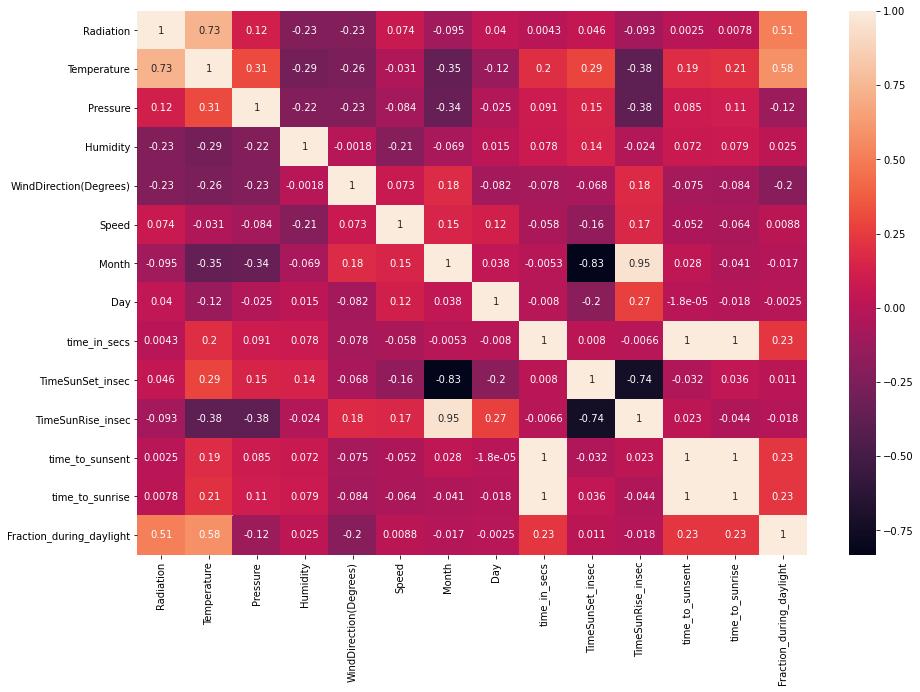

In [130]:
plt.figure(figsize = (15,10))
sns.heatmap(df_clean.corr(),annot=True,)

Not really suprising that the fraction during daylight correlates to Radiation.

**Now that I have finished feature engineering lets get on with the model building.**

In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [23]:
feats = ['Temperature', 'Pressure', 'Humidity',
       'WindDirection(Degrees)', 'Speed', 'Month', 'Day', 'time_in_secs',
       'TimeSunSet_insec', 'TimeSunRise_insec', 'time_to_sunsent',
       'time_to_sunrise', 'Fraction_during_daylight']

In [25]:
X = df[feats].values
y = df['Radiation'].values

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

In [30]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

I first want to try with a simple decision tree

In [110]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV

In [75]:
param_dist = {'max_depth': np.arange(1,20),
             'max_features':['auto', 'sqrt','log2']}
clf = RandomizedSearchCV(DecisionTreeRegressor(), param_dist,cv=10, random_state=42)

In [112]:
clf.fit(X_train,y_train)
clf.best_params_

{'max_features': 'auto', 'max_depth': 11}

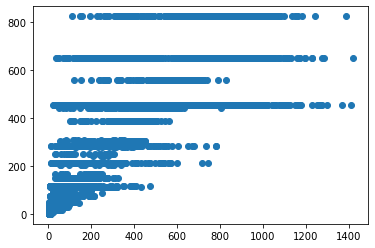

In [113]:
best_tree = DecisionTreeRegressor(max_features= 'auto', max_depth= 5)
best_tree.fit(X_train,y_train)
plt.scatter(y_test,best_tree.predict(X_test))

In [114]:
best_tree.score(X_test, y_test)

0.8411923776645143

Text(0.5, 0, 'Date')

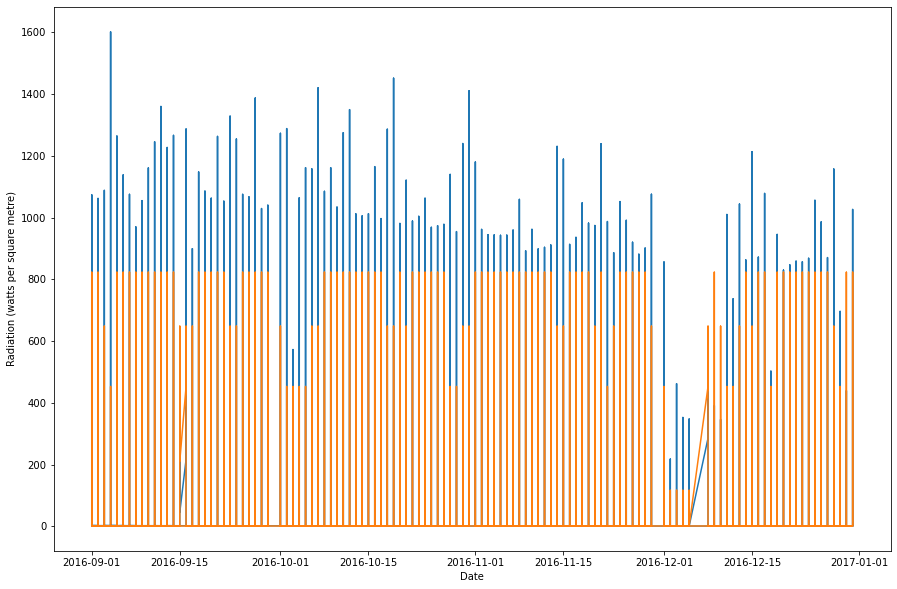

In [133]:
plt.figure(figsize=(15,10))
plt.plot(df.date,df.Radiation)
plt.plot(df.date,best_tree.predict(scaler.transform(X)))
plt.ylabel('Radiation (watts per square metre)')
plt.xlabel('Date')

We can see that although the simple tree picks out the big dip around the start of December, it doesn't do a great job predicting values higher than 800 watts per metre squared. Lets try a random forest

In [115]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

In [116]:
RFR = RandomForestRegressor()
# number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 5)]
# number of features at every split
max_features = ['auto', 'sqrt']
# max depth
max_depth = [int(x) for x in np.linspace(100, 500, num = 5)]
max_depth.append(None)
# create random grid
random_grid = {
 'n_estimators': n_estimators,
 'max_features' : max_features,
 'max_depth': max_depth
 }
# Random search of parameters
RFR_random = RandomizedSearchCV(estimator = RFR, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=1, random_state=2,n_jobs=-1)
# Fit the model
RFR_random.fit(X_train, y_train)
# print results
print(RFR_random.best_params_)

C:\Users\Louis\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:282: UserWarning: The total space of parameters 60 is smaller than n_iter=100. Running 60 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 25.7min finished


{'n_estimators': 1550, 'max_features': 'sqrt', 'max_depth': 100}


Results from random gridsearch are as follows: {'n_estimators': 1550, 'max_features': 'sqrt', 'max_depth': 100}

In [117]:
Best_RFR = RandomForestRegressor(n_estimators=1550, max_depth=100, max_features='sqrt')
Best_RFR.fit(X_train,y_train)
Best_RFR.score(X_test, y_test)


0.9380850298022263

The random forest with the best features does a far better job of predicting the data (R^2 is 0.93 for the random forest compared with 0.84 for the simple tree)

In [ ]:
best_RF_pred_y = Best_RFR.predict(scaler.transform(X))

Text(0.5, 0, 'Date')

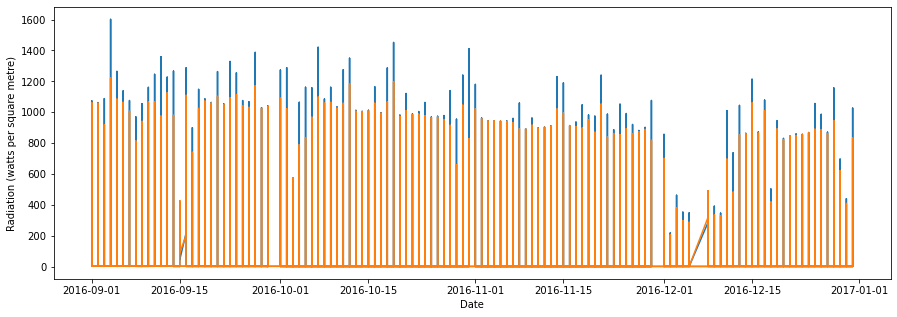

In [136]:
plt.figure(figsize=(15,5))
plt.plot(df.date,df.Radiation)
plt.plot(df.date,best_RF_pred_y)
plt.ylabel('Radiation (watts per square metre)')
plt.xlabel('Date')

The random forest does a much better job at predicting values over 800 w/m2. Lets zoom in and have a better look at a single month, say october.

Text(0.5, 0, 'Date')

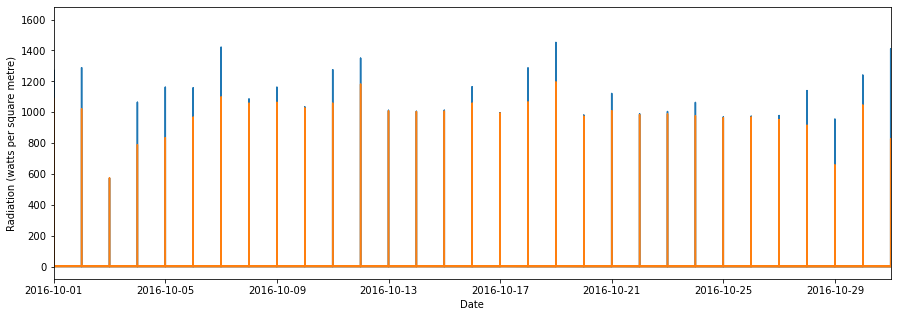

In [145]:
plt.figure(figsize=(15,5))
plt.plot(df.date,df.Radiation)
plt.plot(df.date,best_RF_pred_y)
plt.xlim([datetime.date(2016, 10, 1), datetime.date(2016, 10, 31)])
plt.ylabel('Radiation (watts per square metre)')
plt.xlabel('Date')

Text(0.5, 0, 'y_test')

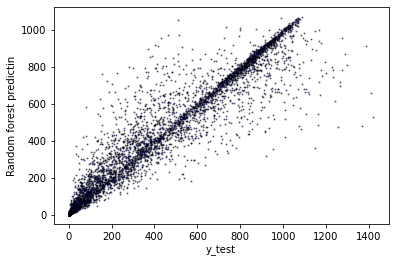

In [143]:
plt.plot(y_test,Best_RFR.predict(X_test),
         linestyle ='none',
         marker='o',
         mfc='blue',
         mec='k',
        alpha=0.5,
        ms=1)
plt.ylabel('Random forest predictin')
plt.xlabel('y_test')

Need to look at methods to get even better than this?